In [6]:
# Forked from excellent kernel : https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features
# From Kaggler : https://www.kaggle.com/jsaguiar
# Just added a few features so I thought I had to make release it as well...

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv


In [7]:
final_df = pd.read_csv('../../datasets/homeCredit/final_train_test.csv')

# LightGBM 模型

In [24]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def kfold_lightgbm(df, num_folds = 5, stratified = True, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM goss. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
        dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)

        # LightGBM parameters found by Bayesian optimization
        params = {
            'objective': 'binary',
            'boosting_type': 'goss',
            'nthread': 5,
            'learning_rate': 0.02,  # 02,
            'num_leaves': 20, #20,33
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'subsample_freq': 0,
            'max_depth': 8, #8,7
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 60, # 60,39
            'seed': 0,
            'verbose': 2000,
            'metric': 'auc',
#             'device' : 'gpu',
#             'gpu_platform_id': 0,
#             'gpu_device_id':0
        }
        
        clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=10000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=200,
            verbose_eval=2000
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
        del clf, dtrain, dvalid
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        sub_df = test_df[['SK_ID_CURR']].copy()
        sub_df['TARGET'] = sub_preds
        sub_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_LightGBM.csv', index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('lgbm_importances01.png')

## boosting_type：gbdt

Starting LightGBM. Train shape: (307507, 871), test shape: (48744, 871)
Training until validation scores don't improve for 200 rounds.
[2000]	training's auc: 0.863144	valid_1's auc: 0.795957
Early stopping, best iteration is:
[2298]	training's auc: 0.871039	valid_1's auc: 0.796118
Fold  1 AUC : 0.796023
Training until validation scores don't improve for 200 rounds.
[2000]	training's auc: 0.863545	valid_1's auc: 0.792145
Early stopping, best iteration is:
[1991]	training's auc: 0.863307	valid_1's auc: 0.7922
Fold  2 AUC : 0.792120
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1656]	training's auc: 0.854168	valid_1's auc: 0.784001
Fold  3 AUC : 0.783884
Training until validation scores don't improve for 200 rounds.
[2000]	training's auc: 0.863315	valid_1's auc: 0.794911
Early stopping, best iteration is:
[1978]	training's auc: 0.862666	valid_1's auc: 0.794989
Fold  4 AUC : 0.795088
Training until validation scores don't improve for 200

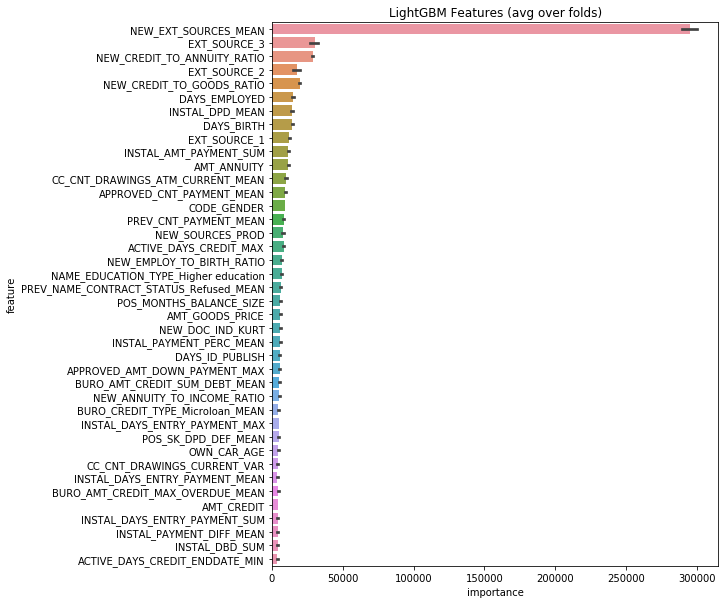

In [21]:
init_time = time.time()
kfold_lightgbm(final_df,10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：goss

Starting LightGBM goss. Train shape: (307507, 871), test shape: (48744, 871)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1665]	training's auc: 0.858418	valid_1's auc: 0.795773
Fold  1 AUC : 0.795745
Training until validation scores don't improve for 200 rounds.
[2000]	training's auc: 0.868368	valid_1's auc: 0.792435
Early stopping, best iteration is:
[2368]	training's auc: 0.878638	valid_1's auc: 0.792827
Fold  2 AUC : 0.792803
Training until validation scores don't improve for 200 rounds.
[2000]	training's auc: 0.868334	valid_1's auc: 0.797239
Early stopping, best iteration is:
[2414]	training's auc: 0.879591	valid_1's auc: 0.797701
Fold  3 AUC : 0.797739
Training until validation scores don't improve for 200 rounds.
[2000]	training's auc: 0.868918	valid_1's auc: 0.793402
Early stopping, best iteration is:
[2328]	training's auc: 0.878128	valid_1's auc: 0.793611
Fold  4 AUC : 0.793615
Training until validation scores don't improve 

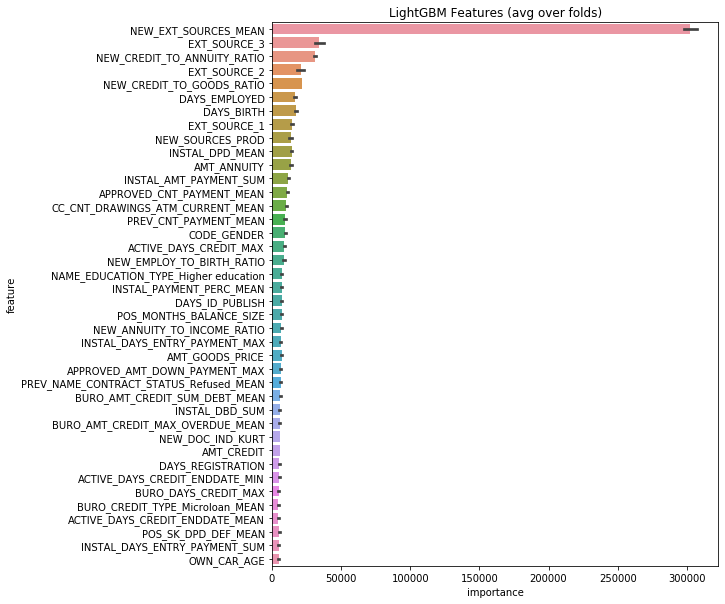

In [25]:
init_time = time.time()
kfold_lightgbm(final_df,10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：dart

Starting LightGBM. Train shape: (307507, 871), test shape: (48744, 871)
Training until validation scores don't improve for 200 rounds.
[2000]	training's auc: 0.806943	valid_1's auc: 0.785508
[4000]	training's auc: 0.838771	valid_1's auc: 0.793737
Early stopping, best iteration is:
[5374]	training's auc: 0.856784	valid_1's auc: 0.794921
Fold  1 AUC : 0.794898
Training until validation scores don't improve for 200 rounds.
[2000]	training's auc: 0.807291	valid_1's auc: 0.783365
[4000]	training's auc: 0.839532	valid_1's auc: 0.791849
Early stopping, best iteration is:
[5115]	training's auc: 0.854683	valid_1's auc: 0.793153
Fold  2 AUC : 0.793169
Training until validation scores don't improve for 200 rounds.
[2000]	training's auc: 0.80788	valid_1's auc: 0.773732
[4000]	training's auc: 0.839702	valid_1's auc: 0.783402
Early stopping, best iteration is:
[5398]	training's auc: 0.858227	valid_1's auc: 0.785734
Fold  3 AUC : 0.785702
Training until validation scores don't improve for 200 rounds.

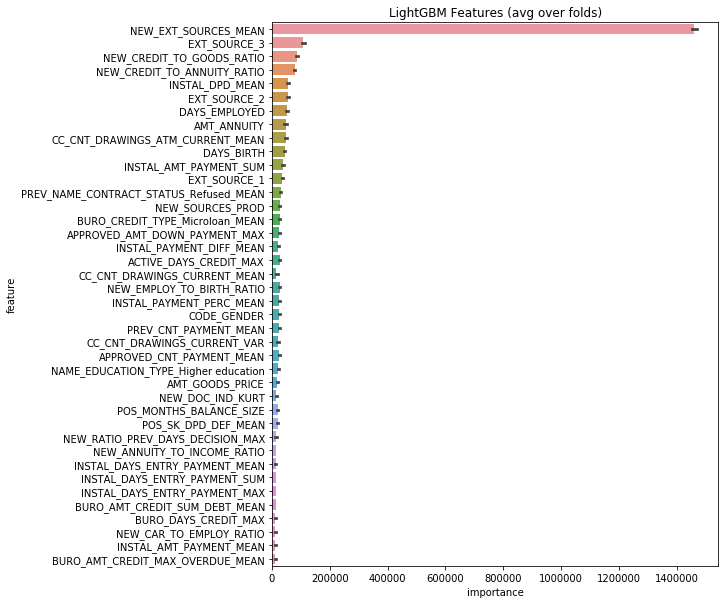

In [10]:
init_time = time.time()
kfold_lightgbm(final_df,10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

## boosting_type：rf

Starting LightGBM. Train shape: (307507, 871), test shape: (48744, 871)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[642]	training's auc: 0.731306	valid_1's auc: 0.731796
Fold  1 AUC : 0.731796
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[46]	training's auc: 0.730785	valid_1's auc: 0.732599
Fold  2 AUC : 0.732599
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[384]	training's auc: 0.731731	valid_1's auc: 0.716284
Fold  3 AUC : 0.716284
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[150]	training's auc: 0.729986	valid_1's auc: 0.733028
Fold  4 AUC : 0.733028
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[41]	training's auc: 0.728981	valid_1's auc: 0.728137
Fold  5 AUC : 0.728137
Training until validation scores don't improve for

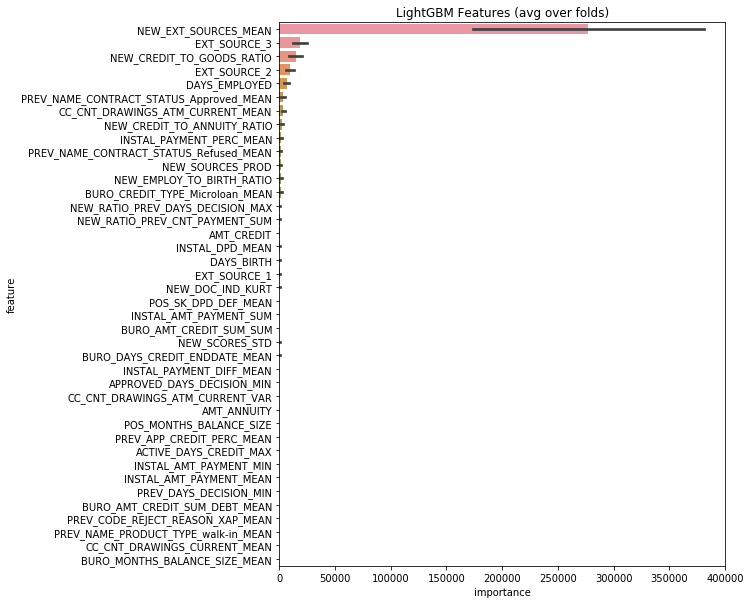

In [17]:
init_time = time.time()
kfold_lightgbm(final_df,10)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

# XGBoost 模型

In [3]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [4]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle

In [23]:
def kfold_xgb(df, num_folds, stratified = True, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting XGBoost. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        #if n_fold == 0: # REmove for full K-fold run
        cuda.select_device(0)
        cuda.close()
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = XGBClassifier(learning_rate =0.01, 
                            n_estimators=5000, 
                            max_depth=4, 
                            min_child_weight=5,
#                             tree_method='gpu_hist',
                            subsample=0.8, 
                            colsample_bytree=0.8, 
                            objective= 'binary:logistic',
                            nthread=4,
                            scale_pos_weight=2.5,
                            seed=28,
                            reg_lambda = 1.2)
        
#         clf = pickle.load(open('test.pickle','rb'))
        
        cuda.select_device(0)
        cuda.close()
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
        
        cuda.select_device(0)
        cuda.close()
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] # / folds.n_splits # - Uncomment for K-fold 

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

        np.save("xgb_oof_preds_1", oof_preds)
        np.save("xgb_sub_preds_1", sub_preds)
        
        cuda.select_device(0)
        cuda.close()
        
    
    clf = pickle.load(open('test.pickle','rb'))
    # print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_XGBoost_GPU.csv', index= False)
    #display_importances(feature_importance_df)
    #return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBoost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('xgb_importances02.png')

In [17]:
init_time = time.time()
kfold_xgb(final_df, 5)
print("Elapsed time={:5.2f} sec.".format(time.time() - init_time))

Starting XGBoost. Train shape: (307507, 871), test shape: (48744, 871)
[0]	validation_0-auc:0.72139	validation_1-auc:0.719406
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1000]	validation_0-auc:0.801304	validation_1-auc:0.782099
[2000]	validation_0-auc:0.824016	validation_1-auc:0.788724
[3000]	validation_0-auc:0.840526	validation_1-auc:0.790976
[4000]	validation_0-auc:0.853685	validation_1-auc:0.791867
[4999]	validation_0-auc:0.865639	validation_1-auc:0.792425
Fold  1 AUC : 0.792440
[0]	validation_0-auc:0.722441	validation_1-auc:0.714728
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1000]	validation_0-auc:0.802008	validation_1-auc:0.778002
[2000]	validation_0-auc:0.824956	validation_1-auc:0.78592
[3000]	validation_0-auc:0.841242	validation_1-auc:0.788808
[4000]	v

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Elapsed time=62182.09 sec.
